<a href="https://colab.research.google.com/github/gemechisworku/customer-segmentation/blob/main/MUNI_Bootcamp_Customer_Segmentation_for_Marketing_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MUNI Task #2: Customer Segmentation for Marketing Strategies**


**Objective**: Use clustering techniques to segment customers into distinct groups based on purchasing behavior.

**Dataset**: Mall Customer Segmentation Data

**Tasks:**

**Data Exploration:**
    - Load the dataset and inspect its structure and features.
    - Visualize feature distributions using histograms, boxplots, and pairplots.

**Data Preprocessing:**
    - Handle any missing data, if applicable.
    - Depending on the model, you may want to normalize or standardize the numerical features.

**Clustering:**
    Experiment with one or different clustering techniques (like K-means) and try to find the best possible distribution for the provided data.

**Cluster Analysis:**
    - Analyze the characteristics of each cluster.
    - What are the defining characteristics of each group?
    - Try to visualize the clusters using techniques like scatter plots.

**Recommendation for Marketing:**
    - Based on the characteristics of each cluster, what tailored marketing strategies can be derived?
    - For example, if a cluster indicates young customers with high incomes but low spending scores, how can marketing campaigns be designed to target this audience?

**Evaluation**
    - While there might not be a definitive "correct" clustering, try to assess the quality of the formed clusters.

**Improvement**
    - Feature engineering: derive new variables using available features.
    - Experiment with different distance metrics or clustering techniques.

**Conclusion**
    - Summarize the identified customer segments and their significance.
    - Discuss the potential impact of targeted marketing strategies for each segment.
    - Reflect on the clustering technique's effectiveness and areas of improvement.


# **#1 Data Exploration**

We will start with loading and inspecting the data to get better understanding of the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Ignore all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
df = pd.read_csv("/content/drive/My Drive/Datasets/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [36]:
print(df.shape)
print(df.info())


(200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [37]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Visualize the data using histogram to see feature distribution.

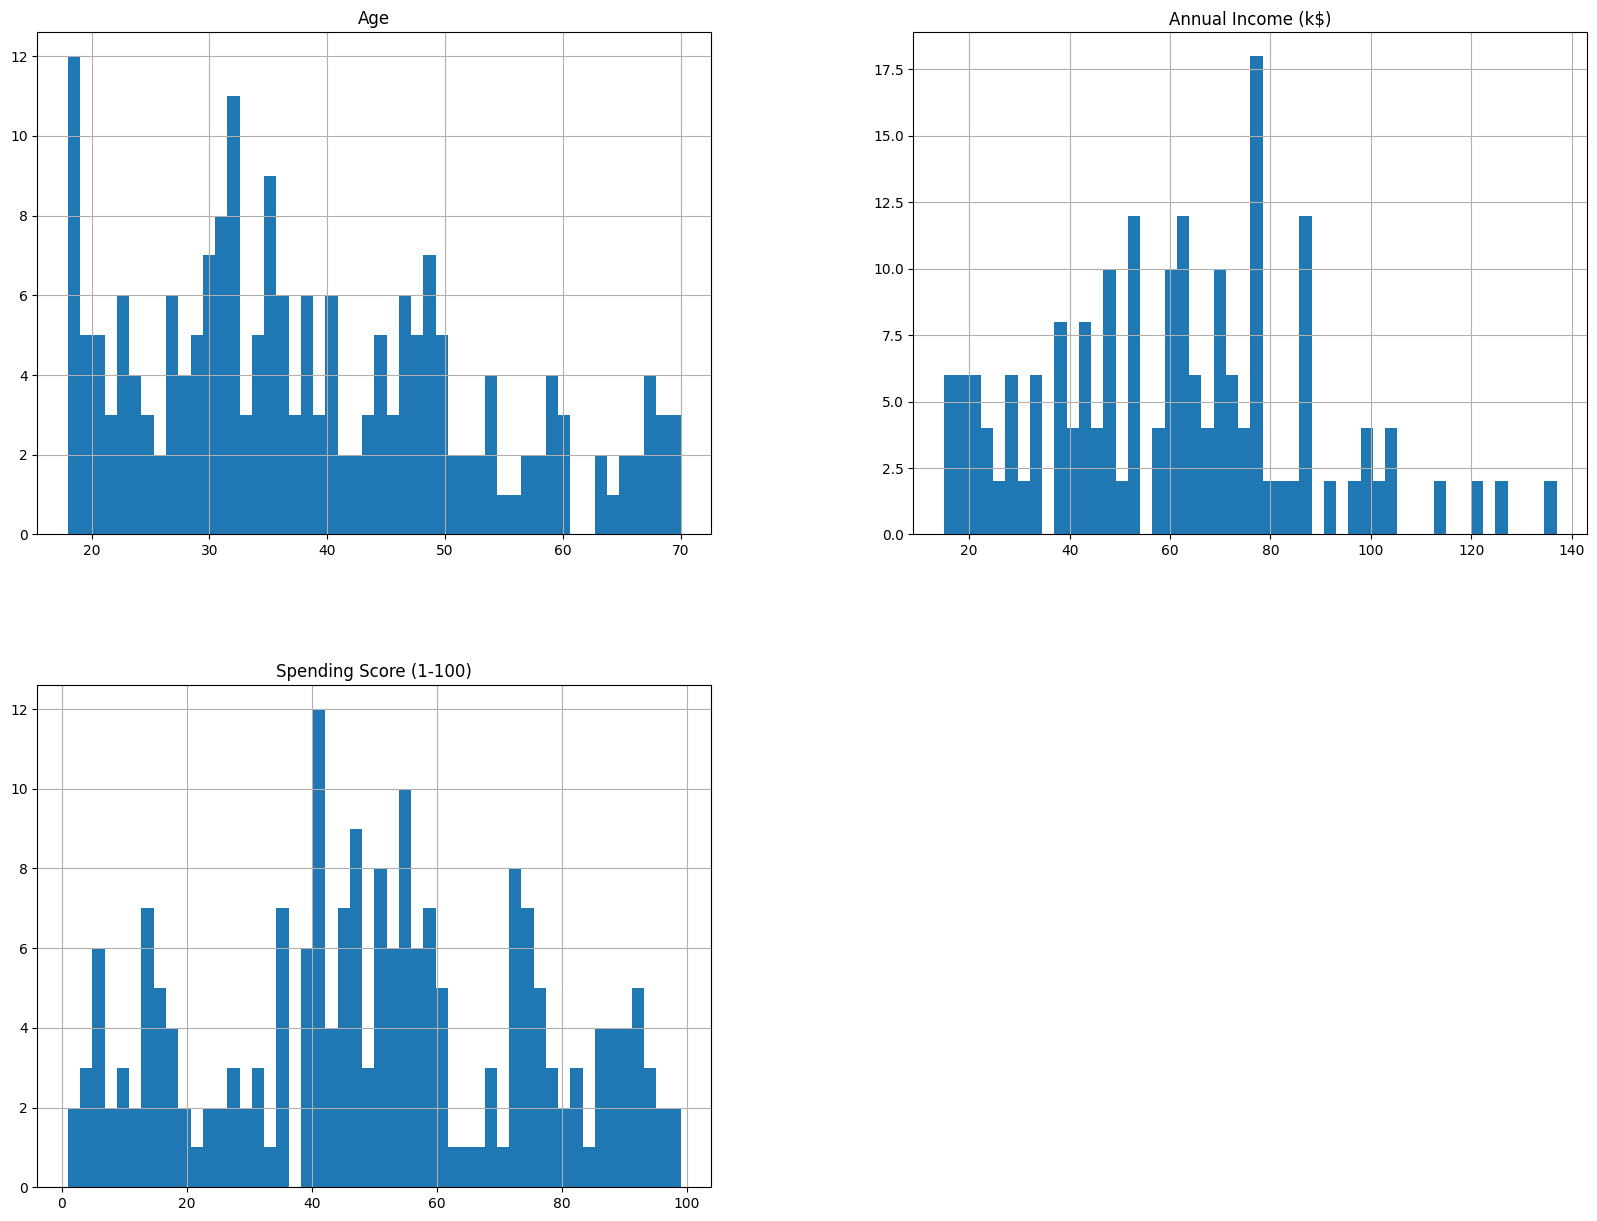

In [38]:
df.drop(columns='CustomerID').hist(bins=50, figsize=(20,15))
plt.show()

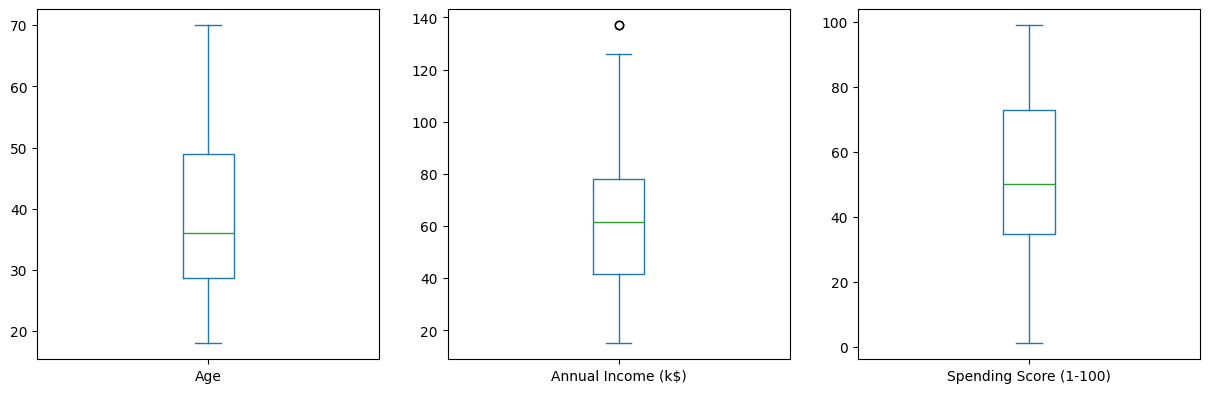

In [39]:
df.drop(columns='CustomerID').plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False, figsize=(15,10))
plt.show()


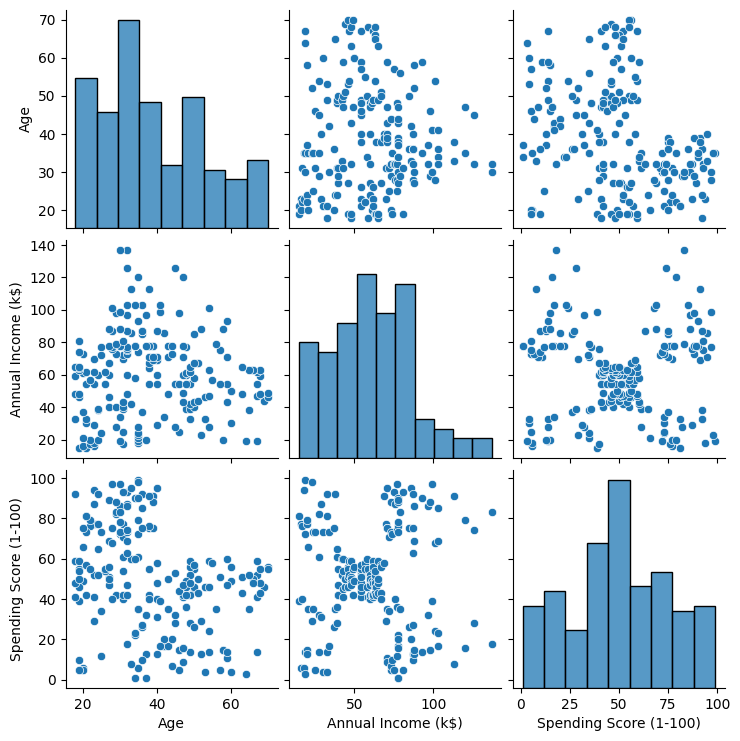

In [40]:
sns.pairplot(df.drop(columns="CustomerID"))
plt.show()

# **#2. Data Preprocessing**

In this step we will check and handle missing data, standardize the numeric data and encode the categorical variables to make them suitable for our models.

## 2.1 Handling a missing data

In [41]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


As it can be observed from above, there is no column with a missing data in our entire dataset. So, we will continue with the encoding of categorical variables.

## 2.2 Feature Endociding

For our model to work, we need to convert the categorical columns to numerical values for processing.

In [42]:
df.select_dtypes("object").head()

,Gender
0,Male
1,Male
2,Female
3,Female
4,Female


Our dataset has only one categorical variable, which is **Gender**. As most machine learning algorithms, including clustering techniques like K-means, require numerical input and cannot directly handle categorical data (non-numeric data such as strings or categories), the categorical data need to encoded.

In [57]:
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

In [58]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Age                     200 non-null    int64
 2   Annual Income (k$)      200 non-null    int64
 3   Spending Score (1-100)  200 non-null    int64
 4   Gender_Male             200 non-null    bool 
dtypes: bool(1), int64(4)
memory usage: 6.6 KB
None


,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,1,19,15,39,True
1,2,21,15,81,True
2,3,20,16,6,False
3,4,23,16,77,False
4,5,31,17,40,False


Now, we have 5 features in total. But, CustomerID is a unique identifier for each customer, serving as a reference or key. It doesn't contain any inherent information about customer behavior, demographics, or purchasing patterns that could help in clustering. Therefore, we will remove the column from our **df**, which could minimize the computing resource and time required for the process.

In [59]:
df.drop(columns="CustomerID", inplace=True)

Once we have finished the encoding of non-numeric features, we will have to standardize the inputs. Standardizing puts all features on the same scale, ensuring that no single feature dominates because of its scale. But, we will be including only numeric columns in the standardization as encoded variables don't need further transformation. Hence, **Gender_Male** feature will be excluded from the features that need to standardized.

##2.3 Standardizing the data

To ensure the data is on the same scale (especially important for clustering), we’ll standardize the features.

In [60]:
df['Gender_Male'].unique()

array([ True, False])

In [61]:
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

df_scaled = pd.DataFrame(df_scaled, columns=features)

df_scaled.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,1.128152
1,-1.281035,-1.738999,1.195704,1.128152
2,-1.352802,-1.700830,-1.715913,-0.886405
3,-1.137502,-1.700830,1.040418,-0.886405
4,-0.563369,-1.662660,-0.395980,-0.886405


# **#3 Clustering**

Clustering is a type of unsupervised machine learning technique used to group a set of objects or data points into clusters, such that objects within the same cluster are more similar to each other than to those in other clusters. This technique is commonly used for exploratory data analysis to discover natural groupings or patterns in the data without prior knowledge of the group labels.

There are many algorithms used for clustering. But, we will be experimenting with **K-means Clustering** algorithm. It partitions data into **k clusters** by minimizing the variance within each cluster. It iteratively assigns data points to the nearest cluster centroid and then recalculates the centroids.

**Centroid** is a central point in a cluster that may represent the mean position of all the points in the cluster.

##3.1 Training a k-clustering model

In this section we will train a k-clustering model and identify the optimum number of clusters.

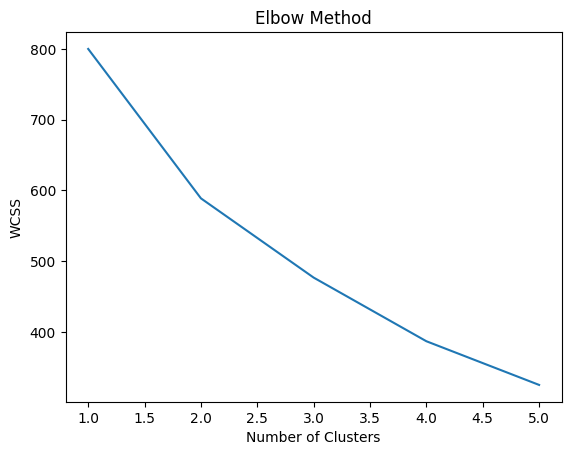

In [77]:
from sklearn.cluster import KMeans

# Elbow Method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares
for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.plot(range(1, 6), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [79]:
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust n_clusters as needed
kmeans.fit(df_scaled)
df['Cluster'] = kmeans.labels_

cluster_summary = df.groupby('Cluster').mean()
cluster_summary


,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
Cluster,,,,
0,56.470588,46.098039,39.313725,0.509804
1,39.500000,85.150000,14.050000,1.000000
2,28.690476,60.904762,70.238095,1.000000
3,37.897959,82.122449,54.448980,0.000000
4,27.315789,38.842105,56.210526,0.000000


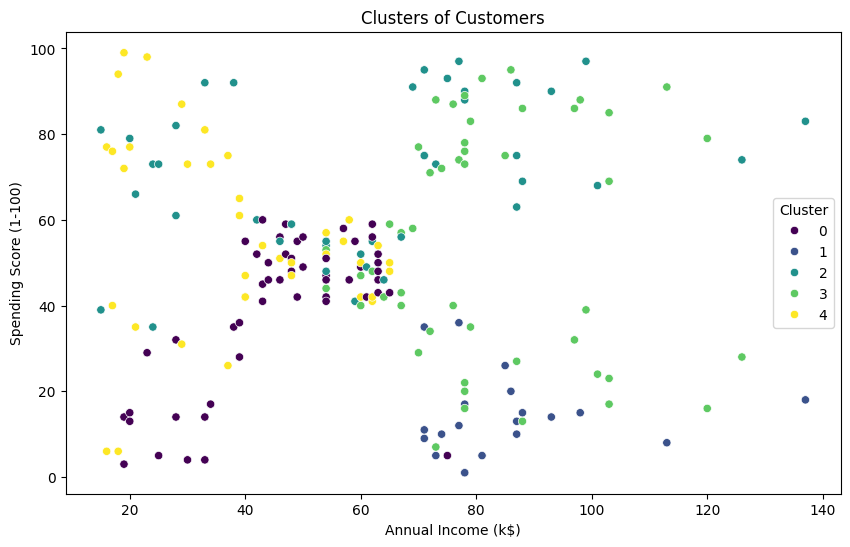

In [80]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=df, palette='viridis')
plt.title('Clusters of Customers')
plt.show()


Using all the features our model is facing difficulty to clearly cluster the data to clear segments. Even thought the silhouette_score is about 0.42, the graph doesn't clearly give has a clear point to determine the optimum number of clusters.

So lets drop the Gender column from our dataframe and check what will happen.

In [91]:
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
df_scaled_new = df_scaled.drop(columns='Gender_Male')
kmeans.fit(df_scaled_new)
df['Cluster'] = kmeans.labels_

cluster_summary = df.drop(columns='Gender_Male').groupby('Cluster').mean()
cluster_summary


,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,50.406250,60.468750,33.343750
1,32.853659,87.341463,79.975610
2,25.142857,43.269841,56.507937


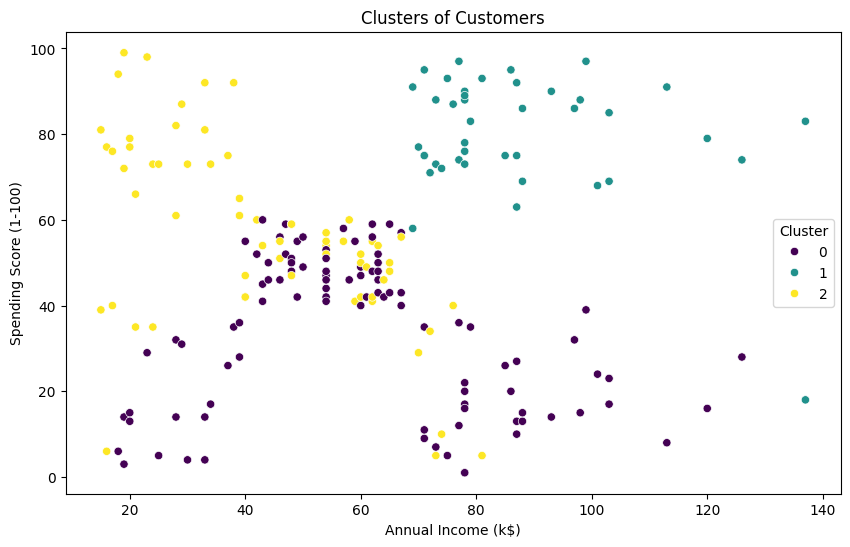

In [89]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=df, palette='viridis')
plt.title('Clusters of Customers')
plt.show()

In [90]:
# Evaluation

score = silhouette_score(df_scaled_new, df['Cluster'])
print('Silhouette Score:', score)

Silhouette Score: 0.3579234303882264


Optimal number of clusters: 3
Maximum silhouette score: 0.3521323147803455


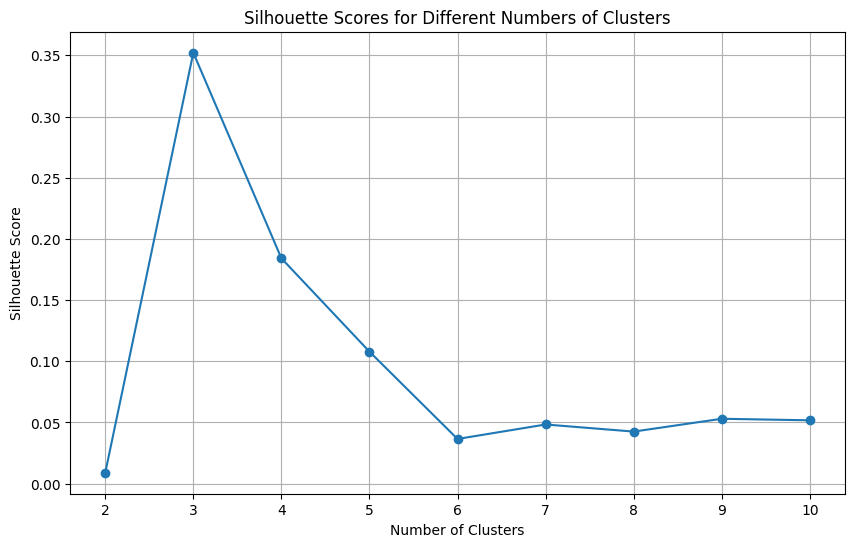

In [86]:
# Define a range of possible values for n_clusters
min_clusters = 2
max_clusters = 10

# Initialize variables to store optimal values
optimal_n_clusters = min_clusters
max_silhouette_score = -1

silhouette_scores = []

# Iterate over different numbers of clusters
for n_clusters in range(min_clusters, max_clusters + 1):
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)

    # Compute the silhouette score
    silhouette_avg = silhouette_score(df_scaled_new, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Update optimal values if silhouette score is higher
    if silhouette_avg > max_silhouette_score:
        max_silhouette_score = silhouette_avg
        optimal_n_clusters = n_clusters

print("Optimal number of clusters:", optimal_n_clusters)
print("Maximum silhouette score:", max_silhouette_score)

# Plotting the silhouette scores for different number of clusters
# Plotting the silhouette scores for different number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.grid(True)
plt.show()

Even thought the silhouette_score is less (0.35), we can now clearly see where the graph is no longer increasing. Therefore, our optimal number of cluster is 3.



In [ ]:
The series of graphs

In [92]:
# Calculate the distance between cluster centroids
cluster_centers = kmeans.cluster_centers_
print(f"Cluster Centroids:\n{cluster_centers}")


Cluster Centroids:
[[ 0.82935381 -0.00348296 -0.65438593]
 [-0.43033758  1.02223317  1.15593564]
 [-0.98371627 -0.65995549  0.24488394]]


#4. Recommendations


In [94]:
# Iterate over each cluster, display cluster characteristics, and define marketing strategies
for cluster_num, cluster_data in cluster_summary.iterrows():
    # Determine cluster type based on income and spending score
    if cluster_data['Annual Income (k$)'] > 50 and cluster_data['Spending Score (1-100)'] > 60:
        cluster_type = "High-Income, High-Spending"
    elif cluster_data['Annual Income (k$)'] < 50 and cluster_data['Spending Score (1-100)'] < 40:
        cluster_type = "Low-Income, Low-Spending"
    else:
        cluster_type = "Moderate-Income, Moderate-Spending"

    # Print cluster details with label
    print(f"Cluster {cluster_num} ({cluster_type}):")
    print(f"  Average Age: {cluster_data['Age']:.1f}")
    print(f"  Annual Income: ${cluster_data['Annual Income (k$)']:.1f}k")
    print(f"  Spending Score: {cluster_data['Spending Score (1-100)']:.1f}")

    # Define marketing strategy based on cluster type
    if cluster_type == "High-Income, High-Spending":
        print("  Recommendation: Target with premium product offerings and loyalty programs to drive repeat purchases.")
        print("  Marketing Approach: Focus on exclusive rewards, early access to products, and high-value offerings.\n")

    elif cluster_type == "Low-Income, Low-Spending":
        print("  Recommendation: Offer discounts, budget-friendly options, and emphasize value-based products.")
        print("  Marketing Approach: Highlight savings, bulk purchasing options, and practical product offerings.\n")

    else:
        print("  Recommendation: Focus on appealing, trendy yet affordable products with limited-time offers.")
        print("  Marketing Approach: Utilize social media and seasonal campaigns to create a sense of urgency and style.\n")


Cluster 0 (Moderate-Income, Moderate-Spending):
  Average Age: 50.4
  Annual Income: $60.5k
  Spending Score: 33.3
  Recommendation: Focus on appealing, trendy yet affordable products with limited-time offers.
  Marketing Approach: Utilize social media and seasonal campaigns to create a sense of urgency and style.

Cluster 1 (High-Income, High-Spending):
  Average Age: 32.9
  Annual Income: $87.3k
  Spending Score: 80.0
  Recommendation: Target with premium product offerings and loyalty programs to drive repeat purchases.
  Marketing Approach: Focus on exclusive rewards, early access to products, and high-value offerings.

Cluster 2 (Moderate-Income, Moderate-Spending):
  Average Age: 25.1
  Annual Income: $43.3k
  Spending Score: 56.5
  Recommendation: Focus on appealing, trendy yet affordable products with limited-time offers.
  Marketing Approach: Utilize social media and seasonal campaigns to create a sense of urgency and style.

